In [1]:
# Import dependencies
%matplotlib inline
import json
import gzip
import urllib.request
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import time
import openweathermapy.core as owm
from datetime import datetime,timedelta
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial
from urllib.error import HTTPError
from IPython.display import display, HTML
import config

errors = []
if config.owm_api_key == '':
    error_message = '\\n'.join(errors)
    js = f'<script>alert("{error_message}");</script>'
    display(HTML(js))
    exit()
print('Openweathermap API key is properly configured')

Openweathermap API key is properly configured


In [2]:
# Shared charts configuration
title_font = {'fontname':'Arial', 'size':20, 'color':'black', 'weight':'semibold' }              
axis_font = {'fontname':'Arial', 'size':16}
legend_font = {'size' : 15 }
ticks_fontsize = 14
marker_size = 14
fig_size = (16, 10)

## Limitations

Bounded by the challenge limitations we have to use weather data available for the free account at `openweathermap.org`. Our account is limited to 60 API calls per minute. Generally, we have two types of data available:

- #### Current Weather at any specified city

    The disadvantage of this approach is that we'll end up comparing weather at different time zones thus the data will naturaly spread. Also if we just take one measurement per city we'll be noised by the temporary weather conditions. The advantage of this approach is that knowing their inner Id of the specific cities (more on where to get it later) we can bundle them in lists up to 25 cities so each bundle will be treated as one API calls.

- #### Forecast for any specified city

    Their forecast is done for next 5 days using 3 hour intervals.  The natural disadvantage is that this is not a real data but a prediction. The advantage is that we could take all these 40 data points (5 days * 24 hours / 3 hour inteval) and take the average value for each metric (reducing the noise generated by temporary conditions)

Ideally, we should perform this kind of research using historical average values for the same period of time expressed in specific time zone's local time but the historical weather is not available for the free account. For this challenge lets stick to the 'current weather' approach

## Building Cities List

Our goal here is to pick at least 500 cities for analysis, they should be evenly distributed across the whole range of latitudes. But since expressing a specific latitude weather by just one city is susceptible to errors lets follow the below algorithm:

1. Load all available cities from `openweathermap.org`
2. Sort them by latitude
3. Take the min an max available latitudes and calculate the available latitude range
4. Split this range into N (1<=N<=500, 1 <= X <= 20, N * X >= 500) subranges where N is number of data points we'd like to see on the charts and X is a number of cities we request weather for per one API call. For every latitude subrange pick X random cities that fall into it (up to X if the actual number of cities in this range is less). This way we'll easily analyze far more than 500 cities
5. For every city bundle perform an API cal for current weather and calculate the average metrics (a median will probably serve better than mean in that case)

This way we'll end up having up to N data points per city group which will be much more representative than the a single data point per city. Also these desired charts will look much cleaner and give higher probability of discovering meaningful trends.

This particular analysis will be done for the values **N=100** and **X=20** (up to 2000 cities). Keeping N lower allows us to reduce the chances that some latitude subranges won't include even a single city

In [3]:
# Initial configuration
interval_count = 100
cities_per_bundle = 20
city_list_url = 'http://bulk.openweathermap.org/sample/city.list.min.json.gz'

# Date we build our analysis for
date = datetime.today()
date_str = date.strftime('%Y-%b-%d')

# OWM settings
settings = {'units': 'imperial', 'appid': config.owm_api_key }
api_call_limit = 60
api_time_limit = 60

In [4]:
# 1. Load all available cities from openweathermap.org
print(f'Loading cities list from {city_list_url} ...')
cities = []
start_time = time.monotonic()
with urllib.request.urlopen(city_list_url) as response:
    with gzip.GzipFile(fileobj=response) as cities_file:
        cities = json.load(cities_file)
elapsed_time = timedelta(seconds=(time.monotonic() - start_time))
print(f'It took {elapsed_time} to load {len(cities)} cities')

Loading cities list from http://bulk.openweathermap.org/sample/city.list.min.json.gz ...
It took 0:00:10.156000 to load 209579 cities


In [5]:
# 2. Sort them by latitude
cities.sort(key=(lambda x: x['coord']['lat']))

In [6]:
# Take a look at 5 southernmost points
cities[:5]

[{'id': 6255152,
  'name': 'Antarctica',
  'country': '',
  'coord': {'lon': 16.40626, 'lat': -78.158562}},
 {'id': 6696480,
  'name': 'McMurdo Station',
  'country': 'AQ',
  'coord': {'lon': 168.222656, 'lat': -77.65535}},
 {'id': 3474415,
  'name': 'South Georgia and the South Sandwich Islands',
  'country': 'GS',
  'coord': {'lon': -33, 'lat': -56}},
 {'id': 3874926,
  'name': 'Puerto Williams',
  'country': 'CL',
  'coord': {'lon': -67.616669, 'lat': -54.933331}},
 {'id': 3864641,
  'name': 'Barrio Almirante Brown',
  'country': 'AR',
  'coord': {'lon': -68.333328, 'lat': -54.816669}}]

In [7]:
# Take a look at 5 northermost points
cities[-5:]

[{'id': 7535696,
  'name': 'Spitsbergen',
  'country': 'SJ',
  'coord': {'lon': 17.709961, 'lat': 78.052902}},
 {'id': 7521757,
  'name': 'Svalbard',
  'country': 'SJ',
  'coord': {'lon': 15.86426, 'lat': 78.157059}},
 {'id': 2729456,
  'name': 'Nybyen',
  'country': 'SJ',
  'coord': {'lon': 15.59119, 'lat': 78.201851}},
 {'id': 2729907,
  'name': 'Longyearbyen',
  'country': 'SJ',
  'coord': {'lon': 15.64007, 'lat': 78.218597}},
 {'id': 5984185,
  'name': 'Isachsen',
  'country': 'CA',
  'coord': {'lon': -103.504761, 'lat': 78.785301}}]

In [8]:
# There are only two Antarctica-related points (09/06/18) but they are so far away from real cities that
# there will be a huge interval with no cities at all. Lets just remove them. No outliers from the northern side
cities = cities[2:]
cities[0]

{'id': 3474415,
 'name': 'South Georgia and the South Sandwich Islands',
 'country': 'GS',
 'coord': {'lon': -33, 'lat': -56}}

In [9]:
# 3. Take the min an max available latitudes and calculate the available latitude range
northernmost = cities[-1]
southernmost = cities[0]
min_latitude = southernmost['coord']['lat']
max_latitude = northernmost['coord']['lat']
latitude_range = max_latitude - min_latitude
print(f'The southernmost point is {southernmost["name"]},{southernmost["country"]}',end='')
print(f' at ({southernmost["coord"]["lat"]}, {southernmost["coord"]["lon"]})')
print(f'The northernmost point is {northernmost["name"]},{northernmost["country"]}',end='')
print(f' at ({northernmost["coord"]["lat"]}, {northernmost["coord"]["lon"]})')
print(f'All available latitudes are covered by the range of {latitude_range:.6f}°')

The southernmost point is South Georgia and the South Sandwich Islands,GS at (-56, -33)
The northernmost point is Isachsen,CA at (78.785301, -103.504761)
All available latitudes are covered by the range of 134.785301°


In [10]:
# 4. Split this range into N subranges
city_groups = [[] for _ in range(interval_count)]
city_latitudes = [city['coord']['lat'] for city in cities]
latitude_bins = np.linspace(min_latitude, max_latitude, num=interval_count)
city_bin_indices = np.digitize(city_latitudes, latitude_bins)
for i in range(len(cities)):
    city = cities[i]
    # Also lets join the city and country names
    city['full_name'] = f'{city["name"]},{city["country"]}'
    bin_index = city_bin_indices[i] - 1
    city_groups[bin_index].append(city)

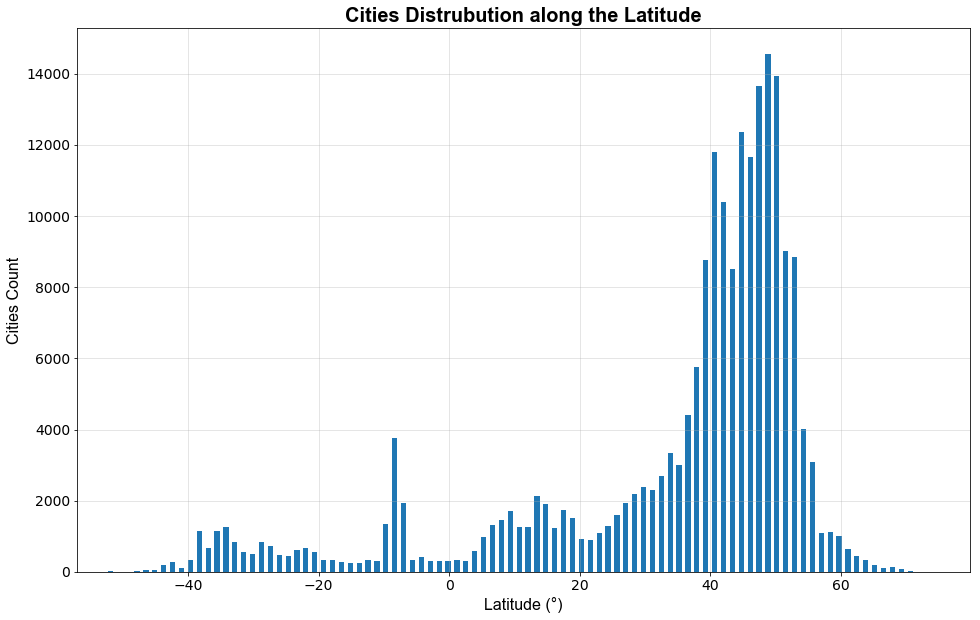

In [11]:
# Lets just take a peek at how cities are spread across the whole latitude range
cities_count = [len(city_group) for city_group in city_groups]
plt.figure(figsize=fig_size)
plt.bar(latitude_bins, cities_count)
plt.xlabel('Latitude (°)', **axis_font)
plt.xlim(min_latitude - 1, max_latitude + 1)
#plt.ylim(21, 99)
plt.xticks(fontsize=ticks_fontsize)
plt.ylabel('Cities Count', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title(f'Cities Distrubution along the Latitude', **title_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/CitiesDistrubution.png')
plt.show()

In [18]:
# For every latitude subrange pick X random cities that fall into it (up to X if the total number of cities
# in this subrange is less than X)  
# Initially set the weather data to empty values
temperature = np.full(len(city_groups),np.NaN,dtype=float)
humidity = np.full(len(city_groups),np.NaN,dtype=int)
cloudiness = np.full(len(city_groups),np.NaN,dtype=int)
wind_speed = np.full(len(city_groups),np.NaN,dtype=float)
city_names = np.full(len(city_groups),'',dtype=object)

total_cities_count = 0
call_count = 0
start_time = time.monotonic()

for i, city_group in enumerate(city_groups):
    city_count_to_pick = min(len(city_group), cities_per_bundle)
    if city_count_to_pick == 0:
        print(f'{i + 1:0>3}: skipping latitude interval ({latitude_bins[i - 1]:.6f},{latitude_bins[i]:.6f}) as there are no cities at all')
        continue
    picked_cities = np.random.choice(city_group, city_count_to_pick, False)
    city_group_name = "\n".join(''.rjust(5) + city['full_name'] for city in picked_cities)
    print(f'{i + 1:0>3}: Retrieving weather for the following cities:')    
    print(city_group_name)
    city_ids = [city['id'] for city in picked_cities]
    try:
        # Since we are limited to 60 API calls per minute we check if our next call is going to break this limit
        if call_count == api_call_limit:
            call_time = time.monotonic() - start_time
            # If it is, then we wait for the remaining time + 1 second
            if call_time < api_time_limit:
                print(''.rjust(5), 'Waiting a bit for not to exceed the API call rate limit')
                time.sleep(api_time_limit - call_time + 1)
            # then we are free to make calls again
            start_time = time.monotonic()
            call_count = 0
        weather_data = owm.get_current_for_group(city_ids, **settings)
        call_count += 1
    except HTTPError as err:
        error_message = json.loads(err.read())['message']
        print(f'{"".rjust(5)}ERROR!{error_message}')
        continue
        
    total_cities_count += city_count_to_pick
    temperature_list = [data('main.temp') for data in weather_data]
    humidity_list = [data('main.humidity') for data in weather_data]
    cloudiness_list = [data('clouds.all') for data in weather_data]
    wind_speed_list = [data('wind.speed') for data in weather_data]
    
    temperature[i] = np.median(temperature_list)
    humidity[i] = np.median(humidity_list)
    cloudiness[i] = np.median(cloudiness_list)
    wind_speed[i] = np.median(wind_speed_list)
    city_names[i] = ", ".join(city['full_name'] for city in picked_cities)

001: Retrieving weather for the following cities:
     Puerto Williams,CL
     South Georgia and the South Sandwich Islands,GS
     Barrio Almirante Brown,AR
     Ushuaia,AR
002: Retrieving weather for the following cities:
     Grytviken,GS
     Río Grande,AR
     Provincia de Tierra del Fuego, Antártida e Islas del Atlántico Sur,AR
     Porvenir,CL
     Kaiken,AR
003: Retrieving weather for the following cities:
     Región de Magallanes y de la Antártica Chilena,CL
     Punta Arenas,CL
     Chabunco,CL
     Río de los Ciervos,CL
004: Retrieving weather for the following cities:
     Yacimiento Rio Turbio,AR
     Rio Gallegos,AR
     Hill Station,AR
     Puerto Natales,CL
     Veintiocho de Noviembre,AR
     Falkland Islands (Islas Malvinas),FK
     Rincon Grande Settlement,FK
     Mare Harbour Rancho,FK
     Stanley,FK
     Puerto Bories,CL
005: Retrieving weather for the following cities:
     Archipel des Kerguelen,TF
     Comandante Luis Piedra Buena,AR
     Port-aux-Francais,TF


024: Retrieving weather for the following cities:
     Las Palomas,PY
     Mokopane,ZA
     Jussara,BR
     Sítio João D. de Oliveira,BR
     Guararema,BR
     Rockhampton,AU
     Ingenio La Esperanza,AR
     Bororen,AU
     Ofcolaco,ZA
     Mochudi,BW
     Departamento de San Pedro,AR
     Embu,BR
     Maimara,AR
     Guapiara,BR
     Cajamar,BR
     Baralaba,AU
     La Mendieta,AR
     Phalaborwa,ZA
     Perico,AR
     Iandrinópolis,BR
025: Retrieving weather for the following cities:
     Socorro,BR
     Cacapava,BR
     Canas,BR
     Chamnanga,ZW
     Naïa,NC
     Dourado,BR
     Karenga,NC
     Cervinho,BR
     Garca,BR
     Lencois Paulista,BR
     Manduri,BR
     Centenario do Sul,BR
     Itapui,BR
     Ocauçu,BR
     Ratholo,BW
     Natércia,BR
     Valinhos,BR
     Santa Maria da Serra,BR
     Sítio Santa Joana,BR
     Ibipora,BR
026: Retrieving weather for the following cities:
     Leopoldina,BR
     Ipiguá,BR
     Fianarantsoa,MG
     Fuerte Olimpo,PY
     Tarija,BO
     Ca

044: Retrieving weather for the following cities:
     Banting,MY
     Villavieja,CO
     Panguruan,ID
     Timbiqui,CO
     Republic of Maldives,MV
     Planadas,CO
     Garbahaarrey,SO
     Makin Village,KI
     Taman Labu Jaya,MY
     Yaounde,CM
     Mentekab,MY
     Kampong Baharu Balakong,MY
     Tarakan,ID
     Kitgum District,UG
     Dolores,CO
     Labuhan Deli,ID
     Lolodorf,CM
     Telok Baharu,MY
     Crucero de Pescador,CO
     Nkan,CM
045: Retrieving weather for the following cities:
     Mega,ET
     Maridi,SS
     Gachancipa,CO
     Bandar Seri Begawan,BN
     Stoelmanseiland,SR
     Palocabildo,CO
     Tonga,CM
     Vodiéko,CI
     Pereira,CO
     Guamo,CO
     El Diamante,CO
     Murillo,CO
     El Aserradero,VE
     Carnot,CF
     Villahermosa,CO
     Sumua-parú-mata,VE
     Harper,LR
     Potaro-Siparuni Region,GY
     Calabar,NG
     Imogwu-Agwa,NG
046: Retrieving weather for the following cities:
     Godo,ET
     El Espino,CO
     Quipama,CO
     Quinchia,CO
   

064: Retrieving weather for the following cities:
     Xitianmu,CN
     Diamondhead,US
     Muḩāfaz̧at al Qalyūbīyah,EG
     Sanlifan,CN
     Muḩāfaz̧at Shamāl Sīnā’,EG
     Sansheng,CN
     Merrydale,US
     Zongluzui,CN
     Longquan,CN
     Jishan,CN
     Al Alamayn,EG
     Zhifang,CN
     Xinwan,CN
     Sirhind,IN
     Fusilier Mobile Home Estates,US
     Wakulla County,US
     Anchang,CN
     Luxiang,CN
     Zhangwu,CN
     Ray City,US
065: Retrieving weather for the following cities:
     Pagnag,CN
     Dasua,IN
     Dongyu,CN
     Mudu,CN
     Fuwah,EG
     Sheikhupura,PK
     Nanyang,CN
     Rafah,PS
     Qingyu,CN
     Jiangduo,CN
     Jonesboro,US
     Xinqiao,CN
     Talmest,MA
     Robinson,US
     Bhakkar,PK
     Harry Manzo,MX
     Puji,CN
     Even Yehuda,IL
     Wilāyat-e Zābul,AF
     Budrus,PS
066: Retrieving weather for the following cities:
     Paosha,CN
     San Jacinto,US
     Shelby,US
     Henry County,US
     Jaurian,IN
     At Taybah,PS
     Byron,US
     Gra

083: Retrieving weather for the following cities:
     Kinross,GB
     Butka,RU
     Loknya,RU
     Zapadnoye Degunino,RU
     Severka,RU
     Mikhaylovskoye,RU
     Borisovskoye,RU
     Ufimskiy,RU
     Pokrovskoye-Streshnëvo,RU
     Medvedkovo,RU
     Bogandinskiy,RU
     East Wemyss,GB
     Savostino,RU
     Uval’yevo,RU
     Kudykino,RU
     Potochino,RU
     Novochernorechenskiy,RU
     Nechaikha,RU
     Kameshkovo,RU
     Nizhniy Novgorod,RU
084: Retrieving weather for the following cities:
     Inčukalna Novads,LV
     Opalikhino,RU
     Balmedie,GB
     Vetlanda,SE
     Dornoch,GB
     Reftele,SE
     Storvorde,DK
     Poddorye,RU
     Ural’skiy,RU
     Mölndals Kommun,SE
     Thane,US
     Ronnang,SE
     Novopanovo,RU
     Fat’yanovo,RU
     Varberg,SE
     Khlyabishino,RU
     Ayat’,RU
     Shukhovo,RU
     Bolshoye Selo,RU
     Monetnyy,RU
085: Retrieving weather for the following cities:
     Mezhdurechenskiy,RU
     Johvi,EE
     Fredrikstad,NO
     Hjelmelandsvagen,NO
  

In [24]:
# Creating a dataframe with all the data
weather_data = pd.DataFrame({
    'Latitude': latitude_bins,
    'Cities': city_names,
    'Temperature': temperature,
    'Humidity': humidity,
    'Cloudiness': cloudiness,
    'Wind Speed': wind_speed
}).dropna(how='any').reset_index(drop=True)
print(f'We have {len(weather_data.index)} data points across the latitude range of {latitude_range:.6f}° which accumulate measurements from {total_cities_count} cities')
weather_data.to_csv('../Output/weather_data.csv',index=False)
weather_data.head()

We have 97 data points across the latitude range of 134.785301° which accumulate measurements from 1760 cities


,Latitude,Cities,Temperature,Humidity,Cloudiness,Wind Speed
0,-56.000000,"Puerto Williams,CL, South Georgia and the Sout...",41.00,60,20,10.290
1,-54.638532,"Grytviken,GS, Río Grande,AR, Provincia de Tier...",27.72,93,0,6.930
2,-53.277065,Región de Magallanes y de la Antártica Chilena...,35.60,93,75,6.930
3,-51.915597,"Yacimiento Rio Turbio,AR, Rio Gallegos,AR, Hil...",37.40,77,40,10.290
4,-50.554129,"Archipel des Kerguelen,TF, Comandante Luis Pie...",34.47,73,6,12.045


## Visualization

### Temperature (°F) vs. Latitude

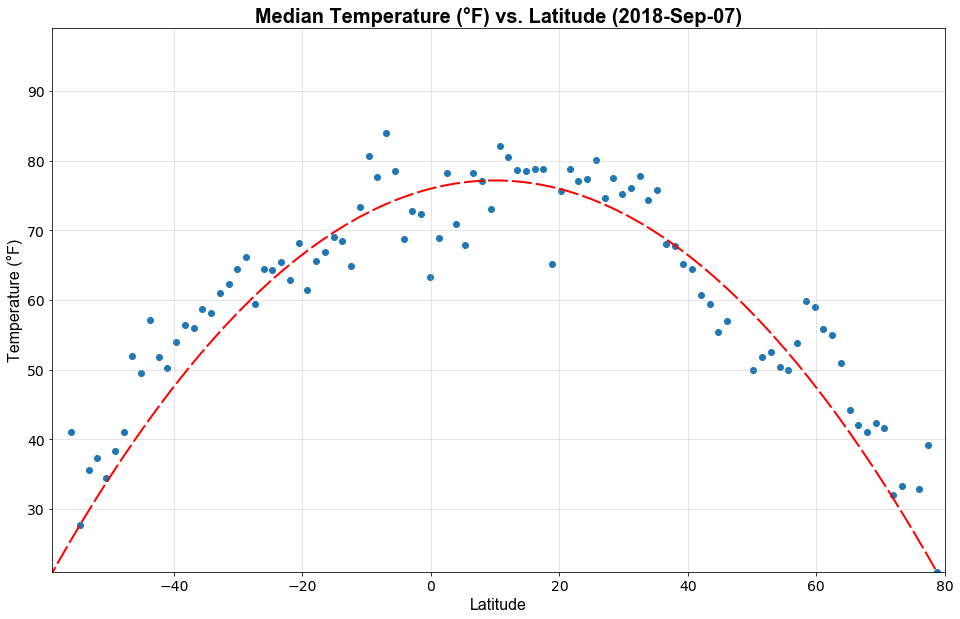

In [25]:
plt.figure(figsize=fig_size)
# Generally, the hotest points lies very close to the equator and the temperature tends to drop away from it.
# This is a great candidate for lagrange polynomial interpolation (see Conclusions)
# I'm going to take one point from the left tail, one from the center, and one from the right tail
index_values = [1, len(weather_data.index) // 2 - 1, len(weather_data.index) - 1]
x_values = [weather_data.loc[i, 'Latitude'] for i in index_values]
y_values = [weather_data.loc[i, 'Temperature'] for i in index_values]
poly = lagrange(x_values, y_values)
x_axis = np.arange(-60, 80)
y_axis = [poly(x) for x in x_axis]
plt.scatter(weather_data['Latitude'], weather_data['Temperature'])
plt.plot(x_axis, y_axis, marker='', linewidth=2, linestyle='dashed', dashes=(10,2), color='red')
plt.xlabel('Latitude', **axis_font)
plt.xlim(-59, 80)
plt.ylim(21, 99)
plt.xticks(fontsize=ticks_fontsize)
plt.ylabel('Temperature (°F)', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title(f'Median Temperature (°F) vs. Latitude ({date_str})', **title_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/Temperature.png')
plt.show()

### Humidity (%) vs. Latitude

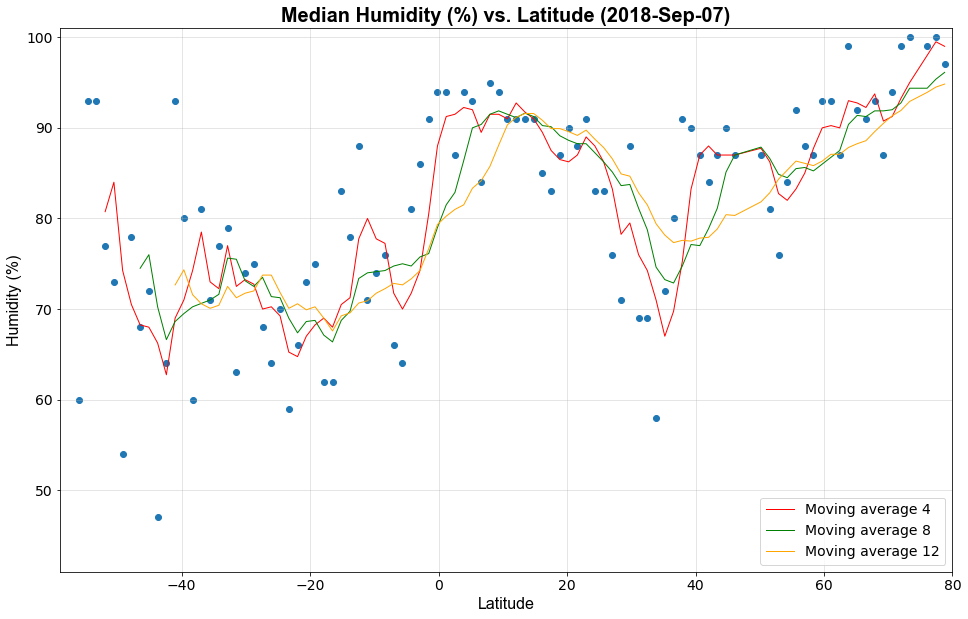

In [26]:
plt.figure(figsize=fig_size)
plt.scatter(weather_data['Latitude'], weather_data['Humidity'])
steps = [4, 8, 12]
colors = ['red', 'green', 'orange']
handles = []
for i in range(len(steps)):
    step = steps[i]
    color = colors[i]
    x_axis = weather_data['Latitude'].rolling(step, center=True).max().dropna()
    y_axis = weather_data['Humidity'].rolling(step, center=True).mean().dropna()
    handle, = plt.plot(x_axis, y_axis, marker='', linewidth=1, linestyle='solid', color=color, label=f'Moving average {step}')
    handles.append(handle)
plt.legend(handles, [handle.get_label() for handle in handles], fontsize=14)
plt.xlabel('Latitude', **axis_font)
plt.xlim(-59, 80)
plt.ylim(41, 101)
plt.xticks(fontsize=ticks_fontsize)
plt.ylabel('Humidity (%)', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title(f'Median Humidity (%) vs. Latitude ({date_str})', **title_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/Humidity.png')
plt.show()

### Cloudiness (%) vs. Latitude

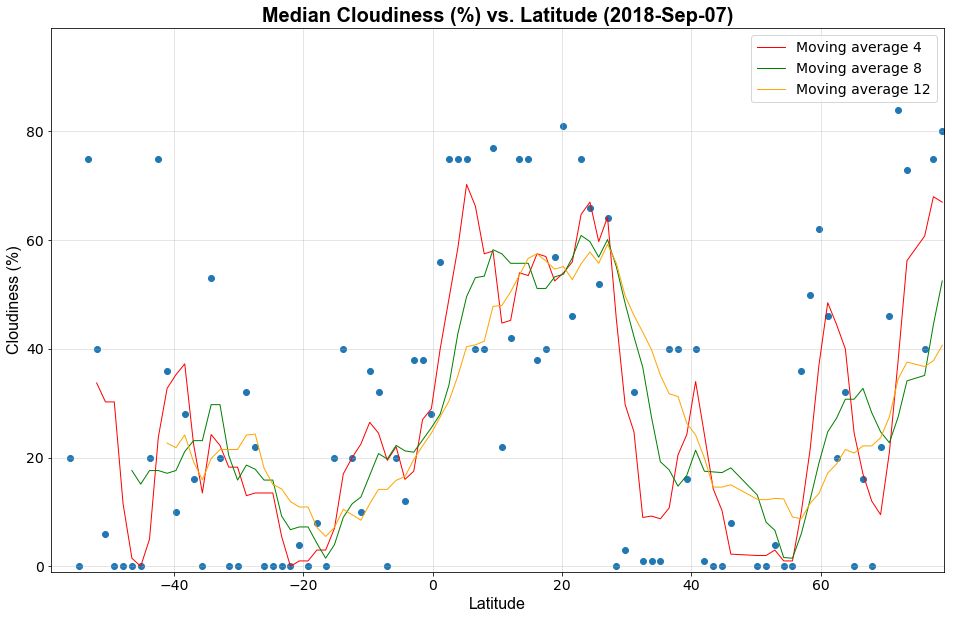

In [27]:
plt.figure(figsize=fig_size)
plt.scatter(weather_data['Latitude'], weather_data['Cloudiness'])
steps = [4, 8, 12]
colors = ['red', 'green', 'orange']
handles = []
for i in range(len(steps)):
    step = steps[i]
    color = colors[i]
    x_axis = weather_data['Latitude'].rolling(step, center=True).max().dropna()
    y_axis = weather_data['Cloudiness'].rolling(step, center=True).mean().dropna()
    handle, = plt.plot(x_axis, y_axis, marker='', linewidth=1, linestyle='solid', color=color, label=f'Moving average {step}')
    handles.append(handle)
plt.legend(handles, [handle.get_label() for handle in handles], fontsize=14)
plt.xlabel('Latitude', **axis_font)
plt.xlim(-59, 79)
plt.ylim(-1, 99)
plt.xticks(fontsize=ticks_fontsize)
plt.ylabel('Cloudiness (%)', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title(f'Median Cloudiness (%) vs. Latitude ({date_str})', **title_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/Cloudiness.png')
plt.show()

### Wind Speed (mph) vs. Latitude

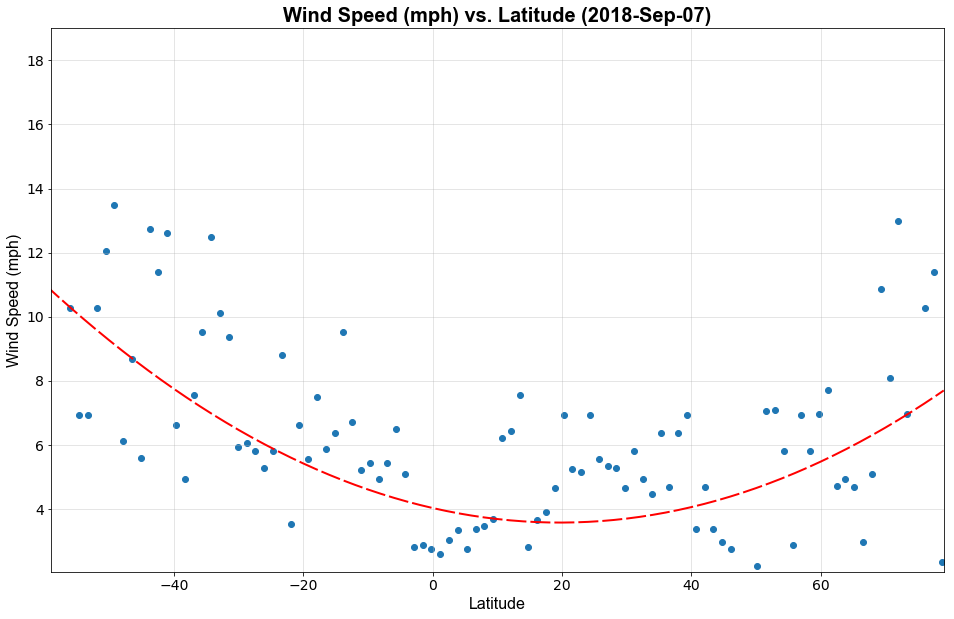

In [29]:
plt.figure(figsize=fig_size)
plt.scatter(weather_data['Latitude'], weather_data['Wind Speed'])
# Generally, the wind is weaker at the equator and it gets stronger the farther from it we go
# This is a great candidate for lagrange polynomial interpolation (see Conclusions)
# I'm going to take one point from the left tail, one from the center, and one from the right tail
index_values = [0, len(weather_data.index) // 2, len(weather_data.index) - 4]
x_values = [weather_data.loc[i, 'Latitude'] for i in index_values]
y_values = [weather_data.loc[i, 'Wind Speed'] for i in index_values]
poly = lagrange(x_values, y_values)
x_axis = np.arange(-60, 80)
y_axis = [poly(x) for x in x_axis]
plt.plot(x_axis, y_axis, marker='', linewidth=2, linestyle='dashed', dashes=(10,2), color='red')

plt.xlabel('Latitude', **axis_font)
plt.xlim(-59, 79)
plt.ylim(2.05, 19)
plt.xticks(fontsize=ticks_fontsize)
plt.ylabel('Wind Speed (mph)', **axis_font)
plt.yticks(fontsize=ticks_fontsize)
plt.title(f'Wind Speed (mph) vs. Latitude ({date_str})', **title_font)
plt.grid(alpha=0.4)
plt.savefig('../Output/Charts/WindSpeed.png')
plt.show()

## Conclusions
1. The temperature is clearly at it max around 10° latitude and gradually drops when we move away from it in both the northern and the southern directions
2. The same ≈10° latitude corresponds to the high peak of the humidity and gradually drops away from it in both directions. Going north, its reaches its low peak at ≈40° and gradually rises back to the equatorial values. Going south, the spread of the available values is too high to make any conclusions
3. Generally the most clody areas are those between 0 and 30° latitude. Also there is a notable range between -35° and -15° where clouds are extremly rare
4. Generally a near-zero latitudes tend to be quite quiet while moving away from them increases our chances to be caught in a heavy wind

The temperature, humidity and wind speed peaks related to 0-20° latitudes can be explained by the Earth axial tilt